In [32]:
import pandas as pd
import numpy as np
from sksurv.nonparametric import kaplan_meier_estimator as kmf
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
import matplotlib.patches as mpatches

In [33]:
selected_cell = 'LSEC'

In [34]:
estimation = pd.read_csv('GSE14520.Endothelium.csv',index_col=0)
estimation.head()

,LVECt,Other,LSEC,Hepatocytes,LVEC,Carcinoma,P-value,Correlation,RMSE
Mixture,,,,,,,,,
GSM362947,0.0,0.014501,0.0,0.434108,0.021229,0.530163,0,0.778485,0.628374
GSM362948,0.0,0.034410,0.0,0.378055,0.000000,0.587535,0,0.414379,0.960348
GSM362949,0.0,0.030584,0.0,0.334476,0.033838,0.601102,0,0.416311,0.939923
GSM362950,0.0,0.045867,0.0,0.353975,0.006606,0.593553,0,0.632050,0.776613
GSM362951,0.0,0.033322,0.0,0.712279,0.043644,0.210755,0,0.893454,0.573338


In [35]:
survival_data = pd.read_csv('GSE14520.Survival.csv',index_col=0)
survival_data.head()

,OS_E,OS,DFS_E,DFS
GSM,,,,
GSM363205,0,58.0,0,58.0
GSM363115,0,66.6,0,66.6
GSM362970,0,67.3,0,67.3
GSM363354,1,10.4,1,10.4
GSM363039,0,52.8,0,52.8


In [36]:
dfs_data = survival_data.filter(['DFS_E', 'DFS'])
dfs_data = dfs_data.dropna(axis=0,how='any')
binary = {1:True,0:False}
dfs_data['DFS_E'] = [binary[event] for event in dfs_data['DFS_E']]
dfs_data['DFS_T'] = [time for time in dfs_data['DFS']]
dfs_data.head()

,DFS_E,DFS,DFS_T
GSM,,,
GSM363205,False,58.0,58.0
GSM363115,False,66.6,66.6
GSM362970,False,67.3,67.3
GSM363354,True,10.4,10.4
GSM363039,False,52.8,52.8


In [37]:
survival_test = estimation.merge(dfs_data,left_index=True,right_index=True,how='inner')
survival_test.head()

,LVECt,Other,LSEC,Hepatocytes,LVEC,Carcinoma,P-value,Correlation,RMSE,DFS_E,DFS,DFS_T
GSM362947,0.0,0.014501,0.0,0.434108,0.021229,0.530163,0,0.778485,0.628374,True,50.0,50.0
GSM362948,0.0,0.034410,0.0,0.378055,0.000000,0.587535,0,0.414379,0.960348,True,8.8,8.8
GSM362949,0.0,0.030584,0.0,0.334476,0.033838,0.601102,0,0.416311,0.939923,True,18.2,18.2
GSM362950,0.0,0.045867,0.0,0.353975,0.006606,0.593553,0,0.632050,0.776613,True,30.1,30.1
GSM362952,0.0,0.000000,0.0,0.590247,0.010210,0.399544,0,0.876666,0.512594,False,54.3,54.3


In [38]:
survival_reorder = survival_test.sort_values(selected_cell,axis=0,ascending=False)
survival_reorder.head()

,LVECt,Other,LSEC,Hepatocytes,LVEC,Carcinoma,P-value,Correlation,RMSE,DFS_E,DFS,DFS_T
GSM363168,0.000000,0.082769,0.194162,0.164589,0.022671,0.535810,0,0.042787,1.076129,False,53.8,53.8
GSM363184,0.135431,0.018742,0.040144,0.015233,0.171410,0.619040,0,0.087896,1.032174,False,16.3,16.3
GSM363243,0.000000,0.063176,0.004456,0.750933,0.000000,0.181435,0,0.929126,0.536437,False,55.8,55.8
GSM363035,0.003026,0.023419,0.002819,0.899310,0.005722,0.065705,0,0.918928,0.759978,True,24.6,24.6
GSM362971,0.000000,0.060532,0.002038,0.747473,0.012228,0.177730,0,0.931421,0.526193,True,40.4,40.4


In [39]:
running_length = len(survival_reorder)

logrank_tests = []
cut_points = []

for i in range(running_length):
    cut_point = int(i+1)
    E = list(survival_reorder['DFS_E'])
    mid_point = int(len(E)/2)
    E_high = E[:cut_point]
    E_low = E[cut_point:]
    S = list(survival_reorder['DFS_T'])
    S_high = S[:cut_point]
    S_low = S[cut_point:]
    results = logrank_test(S_high,S_low,E_high,E_low)
    p = results.p_value
    cut_points.append(cut_point)
    logrank_tests.append(p)

optimization = pd.DataFrame(logrank_tests,index=cut_points,columns=['Log Rank Test'])

In [40]:
#optimization = optimization.dropna()
#optimization = optimization.sort_values('Log Rank Test')
#optimization = int(optimization.iloc[0].name)
optimization = int(len(E)/2)

In [41]:
dfs_cut_level = survival_reorder[selected_cell][optimization]
dfs_cut_level

0.0

In [42]:
E = list(survival_reorder['DFS_E'])
cut_point = optimization
E_high = E[:cut_point]
E_low = E[cut_point:]
S = list(survival_reorder['DFS_T'])
S_high = S[:cut_point]
S_low = S[cut_point:]
results = logrank_test(S_high,S_low,E_high,E_low)
p = results.p_value
p = round(p,5)
p

0.62976

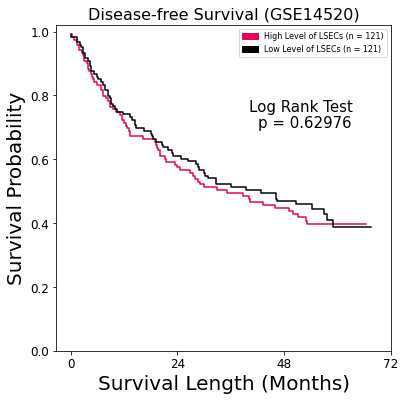

In [43]:
plt.figure(figsize=(6,6))
t,s = kmf(E_high, S_high)
plt.step(t,s,c='#e6005c')
t,s = kmf(E_low, S_low)
plt.step(t,s,c='k')
plt.xticks(np.arange(0,73,24),fontsize=12)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.xlabel('Survival Length (Months)', fontsize=20)
plt.ylabel('Survival Probability',fontsize=20)
high_patch = mpatches.Patch(color='#e6005c',label='High Level of LSECs (n = %s)'%len(E_high))
low_patch = mpatches.Patch(color='k',label='Low Level of LSECs (n = %s)'%len(E_low))
plt.text(40,0.75, 'Log Rank Test',fontsize=15)
plt.text(42,0.7, 'p = %s'%p,fontsize=15)
plt.legend(handles=[high_patch,low_patch],fontsize=8)
plt.title('Disease-free Survival (GSE14520)',fontsize=16)
plt.savefig('GSE14520.%s.DFS.pdf'%selected_cell,format='pdf')

In [44]:
os_data = survival_data.filter(['OS_E', 'OS'])
os_data = os_data.dropna(axis=0,how='any')
binary = {1:True,0:False}
os_data['OS_E'] = [binary[event] for event in os_data['OS_E']]
os_data['OS_T'] = [time for time in os_data['OS']]
os_data.head()

,OS_E,OS,OS_T
GSM,,,
GSM363205,False,58.0,58.0
GSM363115,False,66.6,66.6
GSM362970,False,67.3,67.3
GSM363354,True,10.4,10.4
GSM363039,False,52.8,52.8


In [45]:
survival_test = estimation.merge(os_data,left_index=True,right_index=True,how='inner')
survival_test.head()

,LVECt,Other,LSEC,Hepatocytes,LVEC,Carcinoma,P-value,Correlation,RMSE,OS_E,OS,OS_T
GSM362947,0.0,0.014501,0.0,0.434108,0.021229,0.530163,0,0.778485,0.628374,True,59.2,59.2
GSM362948,0.0,0.034410,0.0,0.378055,0.000000,0.587535,0,0.414379,0.960348,False,61.4,61.4
GSM362949,0.0,0.030584,0.0,0.334476,0.033838,0.601102,0,0.416311,0.939923,True,18.2,18.2
GSM362950,0.0,0.045867,0.0,0.353975,0.006606,0.593553,0,0.632050,0.776613,False,57.5,57.5
GSM362952,0.0,0.000000,0.0,0.590247,0.010210,0.399544,0,0.876666,0.512594,False,54.3,54.3


In [46]:
survival_reorder = survival_test.sort_values(selected_cell,axis=0,ascending=False)
survival_reorder

,LVECt,Other,LSEC,Hepatocytes,LVEC,Carcinoma,P-value,Correlation,RMSE,OS_E,OS,OS_T
GSM363168,0.000000,0.082769,0.194162,0.164589,0.022671,0.535810,0,0.042787,1.076129,False,53.8,53.8
GSM363184,0.135431,0.018742,0.040144,0.015233,0.171410,0.619040,0,0.087896,1.032174,False,16.3,16.3
GSM363243,0.000000,0.063176,0.004456,0.750933,0.000000,0.181435,0,0.929126,0.536437,False,55.8,55.8
GSM363035,0.003026,0.023419,0.002819,0.899310,0.005722,0.065705,0,0.918928,0.759978,False,56.1,56.1
GSM362971,0.000000,0.060532,0.002038,0.747473,0.012228,0.177730,0,0.931421,0.526193,True,48.1,48.1
...,...,...,...,...,...,...,...,...,...,...,...,...
GSM363107,0.002277,0.018123,0.000000,0.699928,0.002466,0.277207,0,0.810011,0.721204,True,7.0,7.0
GSM363108,0.000000,0.033330,0.000000,0.723342,0.005244,0.238083,0,0.937515,0.482473,False,48.8,48.8
GSM363109,0.000000,0.058499,0.000000,0.375075,0.000000,0.566426,0,0.068933,1.188624,False,55.2,55.2
GSM363115,0.002886,0.071170,0.000000,0.687740,0.005184,0.233020,0,0.870431,0.598338,False,66.6,66.6


In [47]:
running_length = len(survival_reorder)

logrank_tests = []
cut_points = []

for i in range(running_length):
    cut_point = int(i+1)
    E = list(survival_reorder['OS_E'])
    mid_point = int(len(E)/2)
    E_high = E[:cut_point]
    E_low = E[cut_point:]
    S = list(survival_reorder['OS_T'])
    S_high = S[:cut_point]
    S_low = S[cut_point:]
    results = logrank_test(S_high,S_low,E_high,E_low)
    p = results.p_value
    cut_points.append(cut_point)
    logrank_tests.append(p)

optimization = pd.DataFrame(logrank_tests,index=cut_points,columns=['Log Rank Test'])

In [48]:
#optimization = optimization.dropna()
#optimization = optimization.sort_values('Log Rank Test')
#optimization = int(optimization.iloc[0].name)
optimization = int(len(E)/2)

In [49]:
os_cut_level = survival_reorder[selected_cell][optimization]
os_cut_level

0.0

In [50]:
E = list(survival_reorder['OS_E'])
cut_point = optimization
E_high = E[:cut_point]
E_low = E[cut_point:]
S = list(survival_reorder['OS_T'])
S_high = S[:cut_point]
S_low = S[cut_point:]
results = logrank_test(S_high,S_low,E_high,E_low)
p = results.p_value
p = round(p,5)
p

0.76289

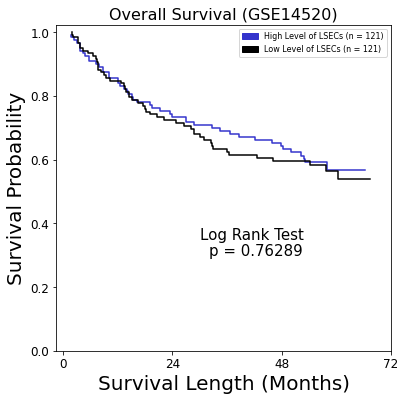

In [51]:
plt.figure(figsize=(6,6))
t,s = kmf(E_high, S_high)
plt.step(t,s,c='#3333cc')
t,s = kmf(E_low, S_low)
plt.step(t,s,c='k')
plt.xticks(np.arange(0,73,24),fontsize=12)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.xlabel('Survival Length (Months)', fontsize=20)
plt.ylabel('Survival Probability',fontsize=20)
high_patch = mpatches.Patch(color='#3333cc',label='High Level of LSECs (n = %s)'%len(E_high))
low_patch = mpatches.Patch(color='k',label='Low Level of LSECs (n = %s)'%len(E_low))
plt.text(30,0.35, 'Log Rank Test',fontsize=15)
plt.text(32,0.3, 'p = %s'%p,fontsize=15)
plt.legend(handles=[high_patch,low_patch],fontsize=8)
plt.title('Overall Survival (GSE14520)',fontsize=16)
plt.savefig('GSE14520.%s.OS.pdf'%selected_cell,format='pdf')

In [52]:
estimation = estimation.sort_values(selected_cell,ascending=False)
x = []
y = []
for key,value in enumerate(estimation[selected_cell]):
    x.append(key)
    y.append(value)

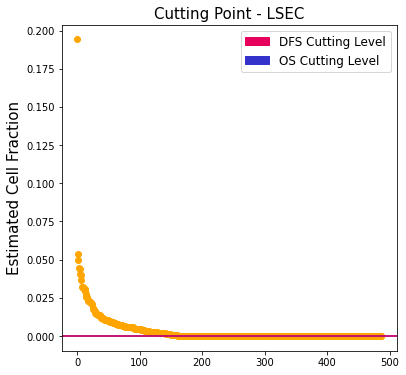

In [53]:
plt.figure(figsize=(6,6))
plt.scatter(x,y,color='orange')
plt.axhline(y=os_cut_level, xmin=0, xmax=100,color='#3333cc')
plt.axhline(y=dfs_cut_level, xmin=0, xmax=100,color='#e6005c')
plt.ylabel('Estimated Cell Fraction',fontsize=15)
plt.title('Cutting Point - %s'%selected_cell,fontsize=15)
dfs_patch = mpatches.Patch(color='#e6005c',label='DFS Cutting Level')
os_patch = mpatches.Patch(color='#3333cc',label='OS Cutting Level')
plt.legend(handles=[dfs_patch,os_patch],fontsize=12)
plt.savefig('Cutting_Point.%s'%selected_cell,format='pdf')